# Несбалансированные выборки. Практическая работа

## Цель практической работы

Научиться обрабатывать несбалансированные данные и обучать модели машинного обучения на таких данных.

## Что входит в работу


1. Загрузить данные и провести разведочный анализ.
2. Разделить данные на обучающую и тестовую выборки.
3. Подготовить данные для моделирования.
4. Сбалансировать данные методом SMOTE и обучить модель машинного обучения.
5. Обучить модель машинного обучения с использованием весов классов и кросс-валидации.
6. Сравнить метрики качества четырёх моделей.




## Что оценивается 

- Выполнены все этапы работы.
- Не допущена утечка данных при разделении выборок и подготовке данных.
- Данные корректным образом сбалансированы.
- Модели не переобучены.


## Как отправить работу на проверку

Скачайте файл с заданиями в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.


# Задача

Пусть у нас имеется некоторый набор данных `german_credit_data.csv` о заёмщиках банка:

* Age — возраст заёмщика.
* Sex — пол заёмщика.
* Job — тип работы заёмщика.
* Housing — тип жилья заёмщика.
* Saving accounts — объём средств на сберегательных счетах заёмщика.
* Checking account — объём средств на основном счёте заёмщика.
* Credit amount — размер кредита. 
* Duration — срок кредита (в месяцах).
* Purpose — цель кредита.
* Risk — таргет, допустил ли заёмщик просрочку платежей по кредиту.

Решите задачу классификации заёмщиков, чтобы банк умел заранее предсказывать просрочку платежей по кредиту. 



# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [3]:
import pandas as pd


df = pd.read_csv('german_credit_data.csv')
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [5]:
df.select_dtypes('object').describe()

,Sex,Housing,Saving accounts,Checking account,Purpose,Risk
count,1000,1000,817,606,1000,1000
unique,2,3,4,3,8,2
top,male,own,little,little,car,good
freq,690,713,603,274,337,700


In [6]:
df.select_dtypes('number').corr()

,Age,Job,Credit amount,Duration
Age,1.000000,0.015673,0.032716,-0.036136
Job,0.015673,1.000000,0.285385,0.210910
Credit amount,0.032716,0.285385,1.000000,0.624984
Duration,-0.036136,0.210910,0.624984,1.000000


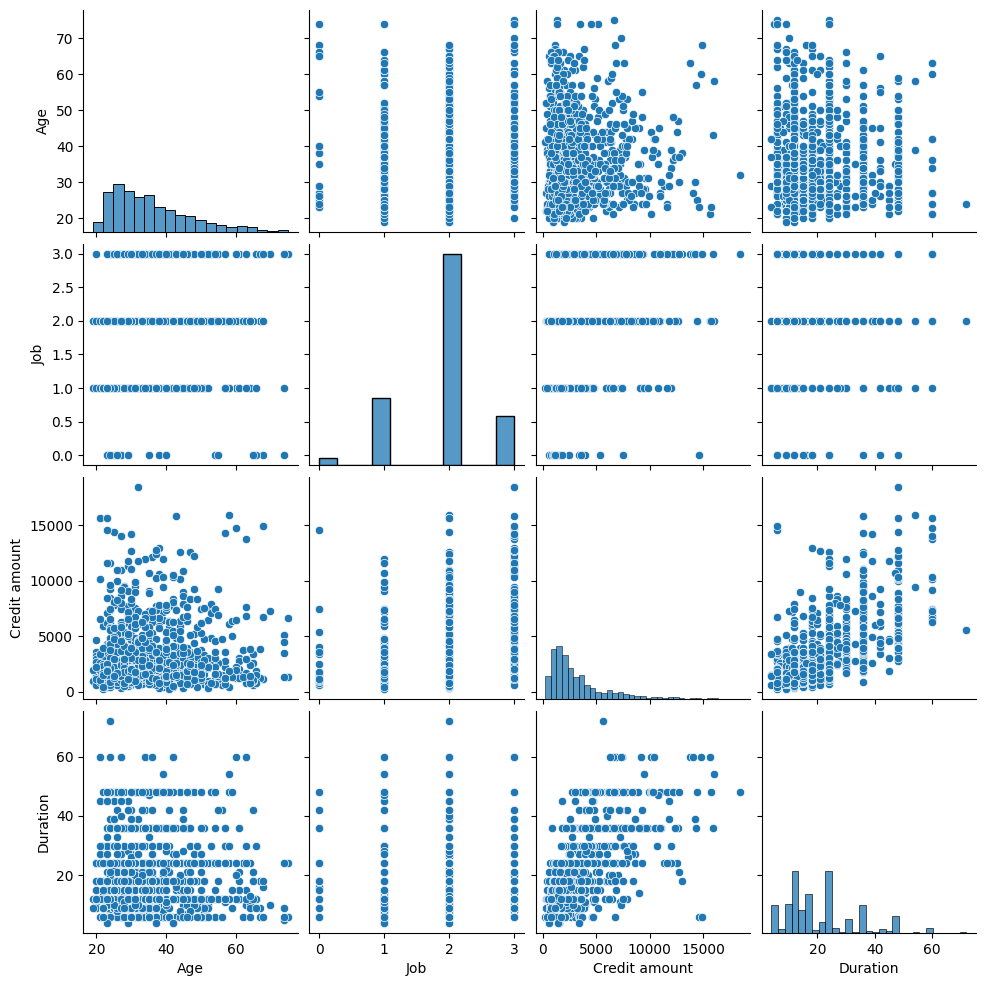

In [7]:
from seaborn import pairplot


pairplot(df);

Целевая переменная имеет дисбаланс классов (70% положительных на 30% отрицательных).

Saving accounts и Checking account имеют значительное количество пропусков.

В Credit amount и Duration присутствуют выбросы.

Сумма кредита положительно коррелирует с его сроком.

# Задание 2

Разделите датасет на обучающую и тестовую выборки в пропорции 80:20. Разделение должно быть стратифицированным по таргету Risk.

В этом и следующих заданиях используйте random_state = 1.

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(df, test_size=0.2, stratify=df['Risk'], random_state=1)

# Задание 3

Проведите этап очистки и подготовки данных (data preparation) и подготовьте данные к моделированию.

In [9]:
x_train['Checking account'].value_counts()

Checking account
little      222
moderate    217
rich         54
Name: count, dtype: int64

In [10]:
# Заполнение пропусков распределением из известных данных
import numpy as np


class_distribution = x_train['Checking account'].value_counts(normalize=True).dropna()
class_distribution_test = x_test['Checking account'].value_counts(normalize=True).dropna()
missing_indices = x_train.index[x_train['Checking account'].isna()]
missing_indices_test = x_test.index[x_test['Checking account'].isna()]

np.random.seed(1)
random_classes = np.random.choice(class_distribution.index, size=len(missing_indices), p=class_distribution.values)
random_classes_test = np.random.choice(class_distribution_test.index, size=len(missing_indices_test), p=class_distribution_test.values)

x_train.loc[missing_indices, 'Checking account'] = random_classes
x_test.loc[missing_indices_test, 'Checking account'] = random_classes_test

In [11]:
x_train['Saving accounts'].value_counts()

Saving accounts
little        485
moderate       90
quite rich     46
rich           36
Name: count, dtype: int64

In [12]:
class_distribution = x_train['Saving accounts'].value_counts(normalize=True).dropna()
class_distribution_test = x_test['Saving accounts'].value_counts(normalize=True).dropna()
missing_indices = x_train.index[x_train['Saving accounts'].isna()]
missing_indices_test = x_test.index[x_test['Saving accounts'].isna()]

np.random.seed(1)
random_classes = np.random.choice(class_distribution.index, size=len(missing_indices), p=class_distribution.values)
random_classes_test = np.random.choice(class_distribution_test.index, size=len(missing_indices_test), p=class_distribution_test.values)

x_train.loc[missing_indices, 'Saving accounts'] = random_classes
x_test.loc[missing_indices_test, 'Saving accounts'] = random_classes_test

In [13]:
# Кодирование бинарныъ признаков
x_train['Sex'] = x_train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
x_test['Sex'] = x_test['Sex'].apply(lambda x: 1 if x == 'male' else 0)
x_train['Risk'] = x_train['Risk'].apply(lambda x: 1 if x == 'good' else 0)
x_test['Risk'] = x_test['Risk'].apply(lambda x: 1 if x == 'good' else 0)

In [14]:
# Кодирование многоклассовых переменных
from sklearn.preprocessing import OneHotEncoder


cat_columns = x_train.select_dtypes('object').columns.to_list()
for col in cat_columns:
    ohe = OneHotEncoder(sparse_output=False)
    ohe.fit(x_train[[col]])
    x_train[ohe.get_feature_names_out()] = ohe.transform(x_train[[col]]).astype(int)
    x_train = x_train.drop([col, ohe.get_feature_names_out()[0]], axis=1)

    x_test[ohe.get_feature_names_out()] = ohe.transform(x_test[[col]]).astype(int)
    x_test = x_test.drop([col, ohe.get_feature_names_out()[0]], axis=1)


# Задание 4

Сбалансируйте обучающую выборку методом SMOTE и обучите модель RandomForestClassifier. Подберите оптимальные гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1, k_neighbors=2)
x_train_sm, y_train_sm = smote.fit_resample(x_train.drop('Risk', axis=1), x_train['Risk'])

In [16]:
y_train_sm.value_counts()

Risk
0    560
1    560
Name: count, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


params = {
    'n_estimators': list(range(25, 150, 25)),
    'max_depth': list(range(8, 33, 8)),
    'max_features': ['sqrt', 'log2'] + list(range(3, 11)),
    'min_samples_leaf': list(range(1, 5)),
    'min_samples_split': list(range(2, 9, 2)),
}

gs = GridSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=1), 
    param_grid=params, 
    scoring='roc_auc',
    cv=3, 
    n_jobs=-1,
)

gs.fit(x_train_sm, y_train_sm)
gs.best_params_, gs.best_score_

({'max_depth': 24,
  'max_features': 3,
  'min_samples_leaf': 1,
  'min_samples_split': 4,
  'n_estimators': 125},
 0.8607918319051867)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rfc = RandomForestClassifier(n_estimators=125, max_depth=24, max_features=3, 
                             min_samples_leaf=1, min_samples_split=4, n_jobs=-1, random_state=1)
rfc.fit(x_train_sm, y_train_sm)

y_prob = rfc.predict_proba(x_test.drop('Risk', axis=1))[:, 1]
roc_auc_score(x_test['Risk'], y_prob)

0.7146428571428571

# Задание 5

Обучите модель RandomForestClassifier с использованием весов классов. Подберите оптимальные веса и гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [23]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(50, 176, 25)),
    'max_depth': list(range(12, 31, 6)),
    'max_features': list(range(2, 11, 2)),
    'min_samples_split': list(range(2, 9, 2)),
    'class_weight': ['balanced', 'balanced_subsample'] + [{0: i, 1: 1} for i in np.arange(1, 11, 2)]
}

gs = GridSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=1), 
    param_grid=params, 
    scoring='roc_auc',
    cv=3, 
    n_jobs=-1
)

gs.fit(x_train.drop('Risk', axis=1), x_train['Risk'])
gs.best_params_, gs.best_score_

({'class_weight': 'balanced',
  'max_depth': 12,
  'max_features': 6,
  'min_samples_split': 6,
  'n_estimators': 50},
 0.6877847497747878)

In [30]:
rfc = RandomForestClassifier(n_estimators=50, max_depth=12, max_features=6, min_samples_split=6, 
                             class_weight='balanced', n_jobs=-1, random_state=1)
rfc.fit(x_train.drop('Risk', axis=1), x_train['Risk'])

y_prob = rfc.predict_proba(x_test.drop('Risk', axis=1))[:, 1]
roc_auc_score(x_test['Risk'], y_prob)

0.6875